In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install mne #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!dir

In [ ]:
from gcpds.databases import GIGA_MI_ME
from typing import Sequence, Tuple
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr
import numpy as np
from scipy.signal import resample

def load_GIGA(db: GIGA_MI_ME,
              sbj: int,
              eeg_ch_names: Sequence[str],
              fs: float, 
              f_bank: np.ndarray, 
              vwt: np.ndarray, 
              new_fs: float) -> Tuple[np.ndarray, np.ndarray]:

  index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

  tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

  db.load_subject(sbj)
  X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
  X = X[:, index_eeg_chs, :] #spatial rearrangement
  X = np.squeeze(tf_repr.transform(X))
  #Resampling
  if new_fs == fs:
    print('No resampling, since new sampling rate same.')
  else:
    print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
    X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
    
  return X, y

from tensorflow.keras.layers import Layer
import tensorflow as tf
import tensorflow_probability as tfp

class GFC(Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.gammad = self.add_weight(name = 'gammad',
                            shape = (),
                            initializer = 'zeros',
                            trainable = True)
    super().build(batch_input_shape)

  def call(self, X): 
    X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
    R = tf.reduce_sum(tf.math.multiply(X, X), axis = -1, keepdims = True) #(N, F, C, 1)
    D  = R - 2*tf.matmul(X, X, transpose_b = (0, 1, 3, 2)) + tf.transpose(R, perm = (0, 1, 3, 2)) #(N, F, C, C)

    ones = tf.ones_like(D[0,0,...]) #(C, C)
    mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
    mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
    mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
    triu = tf.expand_dims(tf.boolean_mask(D, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)
    sigma = tfp.stats.percentile(tf.math.sqrt(triu), 50, axis = 2, keepdims = True) #(N, F, 1, 1)

    A = tf.math.exp(-1/(2*tf.pow(10., self.gammad)*tf.math.square(sigma))*D) #(N, F, C, C)
    A.set_shape(D.shape)
    return A

  def compute_output_shape(self, batch_input_shape):
    N, C, T, F = batch_input_shape.as_list()
    return tf.TensorShape([N, F, C, C])

  def get_config(self):
    base_config = super().get_config()
    return {**base_config}

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Activation, AveragePooling2D, Dropout, SpatialDropout2D, SeparableConv2D, Flatten, Dense
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model

def get_model(number_of_classes: int,
          number_of_channels: int,
          number_of_time_samples: int, 
          dropout_rate: float,
          kernLength: int,
          F1: int, 
          D: int,
          F2: int,
          norm_rate: int,
          dropout_type: str) -> Model:
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      number_of_channels, number_of_time_samples  : number of channels and time points in the EEG data
      dropout_rate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropout_type     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropout_type == 'SpatialDropout2D':
        dropout_type = SpatialDropout2D
    elif dropout_type == 'Dropout':
        dropout_type = Dropout
    else:
        raise ValueError('dropout_type must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input_   = Input(shape = (number_of_channels, number_of_time_samples, 1))

    ##################################################################
    #Temporal Convolution
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                          name = 'Temporal_Conv2D',
                          use_bias = False)(input_)
    block1       = BatchNormalization()(block1)
    adj_mat      = GFC(name = 'gfc')(block1)
    
    ##################################################################
    #Spatial Convolution
    block1       = DepthwiseConv2D((number_of_channels, 1),
                                   name = 'Spatial_Depth_wise_Conv2D',
                                   depth_multiplier = D,
                                   use_bias = False, 
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropout_type(dropout_rate)(block1)
    
    ##################################################################
    #Separable Convolution
    block2       = SeparableConv2D(F2, (1, 16), padding = 'same',
                                   name = 'Separable_Conv2D',
                                   use_bias = False)(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropout_type(dropout_rate)(block2)
    
    ##################################################################
    # Classification block
    flatten      = Flatten(name = 'flatten')(block2)
    dense        = Dense(number_of_classes, name = 'output', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'out_activation')(dense)
    
    return Model(inputs=input_, outputs = [softmax, adj_mat])

from typing import Callable
import tensorflow as tf
import keras.backend as K

def adjacency_matrix_regularization(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
  F = y_pred.shape[1]
  C = y_pred.shape[-1]
  scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude = 1, length_scale = 1e-13)
  y_true = tf.cast(tf.expand_dims(y_true, axis = -1), dtype = tf.float32)
  Ky = scalar_kernely.matrix(y_true, y_true) #(N, N)
  N = Ky.shape[-1]
  Ky = tf.expand_dims(Ky, axis = 0) #(1, N, N)
  ones = tf.ones_like(y_pred[0, 0, ...])
  mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s
  mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s
  mask = tf.cast(mask_a - mask_b, dtype = tf.bool) #Make a bool mask
  A = tf.boolean_mask(y_pred, mask, axis = 2) #(N, F, C(C - 1)/2)
  A.set_shape([N, F, int(C*(C - 1)*0.5)])
  A = tf.linalg.normalize(A, ord = 'euclidean', axis = -1)[0] #Normalize connectivities vectors
  A = tf.transpose(A, perm  = (1, 0, 2)) #(F, N, C(C - 1)/2)
  Ka = tf.linalg.matmul(A, A, transpose_b = True) #(F, N, N)
  h = tf.eye(N) - (1.0/N)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
  trkl = tf.linalg.trace(tf.matmul(tf.matmul(Ka,h), tf.matmul(Ky,h)))
  trkk = tf.linalg.trace(tf.matmul(tf.matmul(Ka,h),tf.matmul(Ka,h)))
  trll = tf.linalg.trace(tf.matmul(tf.matmul(Ky,h),tf.matmul(Ky,h)))
  loss = tf.math.reduce_sum(-trkl/tf.sqrt(trkk*trll))/F
  return loss

In [ ]:
from google.colab.drive import mount
mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TerminateOnNaN
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from os import makedirs

db = GIGA_MI_ME('/content/drive/Shareddrives/GCPDS/databases/GIGA-MI_ME/')
fs = db.metadata['sampling_rate']
eeg_ch_names = ['Fp1','Fpz','Fp2',
              'AF7','AF3','AFz','AF4','AF8',
              'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
              'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
              'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
              'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
              'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
              'PO7','PO3','POz','PO4','PO8',
              'O1','Oz','O2',
              'Iz']
verbose = 0
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 30, verbose = verbose, mode = 'min', min_delta = 0.01, min_lr = 0)
terminate_on_nan = TerminateOnNaN()
callbacks = [reduce_lr_on_plateau, terminate_on_nan]
seed = 23

load_args = dict(db = db,
                 eeg_ch_names = eeg_ch_names,
                 fs = fs,
                 f_bank = np.asarray([[4., 40.]]),
                 vwt = np.asarray([[2.5, 5]]),
                 new_fs = 128.)

cv_args = dict(hyparams = [0, 0.2, 0.4, 0.6, 0.8], #[0, 0.1, 0.2, 0.3]
               cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = seed))

model_args = dict(number_of_classes = 2,
                  dropout_rate = 0.5,
                  kernLength = int(load_args['new_fs']/4),
                  F1 = 8,
                  D = 2,
                  F2 = 16,
                  norm_rate = 0.25,
                  dropout_type = 'Dropout')

compile_args = dict(loss = [SparseCategoricalCrossentropy(), adjacency_matrix_regularization],
                    init_lr = 1e-2)
                        
fit_args = dict(epochs = 500,
                verbose = verbose,
                callbacks = callbacks)

In [ ]:
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score

def train(load_args, cv_args, model_args, compile_args, fit_args, seed):
    X_train, y_train = load_GIGA(**load_args)
    X_train = X_train[..., np.newaxis]

    cv_results = {'params': [], 'mean_acc':[], 'std_acc':[],
                  'mean_kappa':[], 'std_kappa':[],
                  'mean_auc':[], 'std_auc':[]}

    for lambda_ in cv_args['hyparams']:
      cv_results['params'].append(lambda_)
      acc = np.zeros(cv_args['cv'].get_n_splits())
      kappa = np.zeros(cv_args['cv'].get_n_splits())
      auc = np.zeros(cv_args['cv'].get_n_splits())
      k = 0
      for train_index, val_index in cv_args['cv'].split(X_train, y_train):
        X, X_val = X_train[train_index], X_train[val_index]
        y, y_val = y_train[train_index], y_train[val_index]

        batch_size, C, T = X.shape[:-1]

        clear_session()
        set_seed(seed)

        model = get_model(**model_args, number_of_channels = C, number_of_time_samples = T)
        model.compile(loss = compile_args['loss'], 
                      loss_weights = [1 - lambda_, lambda_],
                      optimizer = Adam(compile_args['init_lr']))
        
        history = model.fit(X, [y, y],
                  batch_size = batch_size,
                  **fit_args)

        y_prob = model.predict(X_val)[0]
        y_pred = np.argmax(y_prob, axis = 1)

        acc[k] = accuracy_score(y_val, y_pred)
        kappa[k] = cohen_kappa_score(y_val, y_pred)
        auc[k] = roc_auc_score(y_val, y_prob[:, 1], average = 'macro')

        print('lambda = ', lambda_, ', Fold =  ', k+1, ', acc = ', acc[k])
        k += 1

      cv_results['mean_acc'].append(round(acc.mean(), 3))
      cv_results['std_acc'].append(round(acc.std(), 3))
      cv_results['mean_kappa'].append(round(kappa.mean(), 3))
      cv_results['std_kappa'].append(round(kappa.std(), 3))
      cv_results['mean_auc'].append(round(auc.mean(), 3))
      cv_results['std_auc'].append(round(auc.std(), 3))

    best_score = max(cv_results['mean_acc'])
    index = [idx for idx, val in enumerate(cv_results['mean_acc']) if val == best_score]
    if len(index) == 1:
      best_index = index[0]
    else:
      min_std =  cv_results['std_acc'][index[0]]
      best_index = index[0]
      for idx in index[1:]:
        if min_std > cv_results['std_acc'][idx]:
          min_std = cv_results['std_acc'][idx]
          best_index = idx
        
    cv_results['best_index'] = best_index
            
    print('best param = ', cv_results['params'][cv_results['best_index']], ', best_score = ', best_score)

    #refit

    batch_size, C, T = X_train.shape[:-1]

    clear_session()
    set_seed(seed)

    model = get_model(**model_args, number_of_channels = C, number_of_time_samples = T)
    model.compile(loss = compile_args['loss'],
                  loss_weights = [1 - cv_results['params'][cv_results['best_index']], cv_results['params'][cv_results['best_index']]],
                  optimizer = Adam(compile_args['init_lr']))
    
    history = model.fit(X_train, [y_train, y_train],
              batch_size = batch_size,
              **fit_args)

    model.save_weights('sbj' + str(load_args['sbj']) +'.h5')

    return cv_results

## Test regularizer in some subjects

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([13]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0 , Fold =   1 , acc =  0.925
lambda =  0 , Fold =   2 , acc =  0.875
lambda =  0 , Fold =   3 , acc =  0.875
lambda =  0 , Fold =   4 , acc =  0.95


lambda =  0 , Fold =   5 , acc =  1.0


lambda =  0.001 , Fold =   1 , acc =  0.9
lambda =  0.001 , Fold =   2 , acc =  0.9
lambda =  0.001 , Fold =   3 , acc =  0.875
lambda =  0.001 , Fold =   4 , acc =  0.9
lambda =  0.001 , Fold =   5 , acc =  0.875
lambda =  0.01 , Fold =   1 , acc =  0.85
lambda =  0.01 , Fold =   2 , acc =  0.925
lambda =  0.01 , Fold =   3 , acc =  0.925
lambda =  0.01 , Fold =   4 , acc =  0.875
lambda =  0.01 , Fold =   5 , acc =  0.85
lambda =  0.1 , Fold =   1 , acc =  0.85
lambda =  0.1 , Fold =   2 , acc =  0.85
lambda =  0.1 , Fold =   3 , acc =  0.875
lambda =  0.1 , Fold =   4 , acc =  0.9
lambda =  0.1 , Fold =   5 , acc =  0.85
best param =  0 , best_score =  0.925


In [ ]:
results

{'params': [0, 0.001, 0.01, 0.1],
 'mean_acc': [0.925, 0.89, 0.885, 0.865],
 'std_acc': [0.047, 0.012, 0.034, 0.02],
 'mean_kappa': [0.85, 0.78, 0.77, 0.73],
 'std_kappa': [0.095, 0.024, 0.068, 0.04],
 'mean_auc': [0.971, 0.952, 0.941, 0.949],
 'std_auc': [0.022, 0.02, 0.024, 0.024],
 'best_index': 0}

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([10]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0 , Fold =   1 , acc =  0.775
lambda =  0 , Fold =   2 , acc =  0.9
lambda =  0 , Fold =   3 , acc =  0.8
lambda =  0 , Fold =   4 , acc =  0.775
lambda =  0 , Fold =   5 , acc =  0.75
lambda =  0.2 , Fold =   1 , acc =  0.825
lambda =  0.2 , Fold =   2 , acc =  0.95
lambda =  0.2 , Fold =   3 , acc =  0.925
lambda =  0.2 , Fold =   4 , acc =  0.775
lambda =  0.2 , Fold =   5 , acc =  0.875
lambda =  0.4 , Fold =   1 , acc =  0.825
lambda =  0.4 , Fold =   2 , acc =  0.925
lambda =  0.4 , Fold =   3 , acc =  0.825
lambda =  0.4 , Fold =   4 , acc =  0.825
lambda =  0.4 , Fold =   5 , acc =  0.85
lambda =  0.6 , Fold =   1 , acc =  0.7
lambda =  0.6 , Fold =   2 , acc =  0.9
lambda =  0.6 , Fold =   3 , acc =  0.875
lambda =  0.6 , Fold =   4 , acc =  0.775
lambda =  0.6 , Fold =   5 , acc =  0.85
lambda =  0.8 , Fold =   1 , acc =  0.675
lambda =  0.8 , Fold =   2 , acc =  0.85
lambda =  0.8 , Fold =   3 , acc =  0.9
lambda =  0.8 

In [ ]:
results

{'params': [0, 0.2, 0.4, 0.6, 0.8],
 'mean_acc': [0.8, 0.87, 0.85, 0.82, 0.8],
 'std_acc': [0.052, 0.064, 0.039, 0.073, 0.076],
 'mean_kappa': [0.6, 0.74, 0.7, 0.64, 0.6],
 'std_kappa': [0.105, 0.128, 0.077, 0.146, 0.152],
 'mean_auc': [0.892, 0.938, 0.935, 0.919, 0.887],
 'std_auc': [0.038, 0.043, 0.041, 0.059, 0.072],
 'best_index': 1}

In [ ]:
results

{'params': [0, 0.001, 0.01, 0.1],
 'mean_acc': [0.82, 0.83, 0.845, 0.855],
 'std_acc': [0.051, 0.043, 0.043, 0.066],
 'mean_kappa': [0.64, 0.66, 0.69, 0.71],
 'std_kappa': [0.102, 0.086, 0.086, 0.132],
 'mean_auc': [0.904, 0.935, 0.928, 0.932],
 'std_auc': [0.023, 0.035, 0.036, 0.045],
 'best_index': 3}

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([51]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0 , Fold =   1 , acc =  0.5384615384615384
lambda =  0 , Fold =   2 , acc =  0.6410256410256411
lambda =  0 , Fold =   3 , acc =  0.5641025641025641
lambda =  0 , Fold =   4 , acc =  0.6923076923076923
lambda =  0 , Fold =   5 , acc =  0.6153846153846154
Batch 0: Invalid loss, terminating training


ValueError: ignored

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([51]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0 , Fold =   1 , acc =  0.5384615384615384
lambda =  0 , Fold =   2 , acc =  0.6410256410256411
lambda =  0 , Fold =   3 , acc =  0.5641025641025641
lambda =  0 , Fold =   4 , acc =  0.6923076923076923
lambda =  0 , Fold =   5 , acc =  0.5897435897435898
lambda =  0.2 , Fold =   1 , acc =  0.5128205128205128
lambda =  0.2 , Fold =   2 , acc =  0.6410256410256411
lambda =  0.2 , Fold =   3 , acc =  0.5384615384615384
lambda =  0.2 , Fold =   4 , acc =  0.6666666666666666
lambda =  0.2 , Fold =   5 , acc =  0.6153846153846154
lambda =  0.4 , Fold =   1 , acc =  0.5641025641025641
lambda =  0.4 , Fold =   2 , acc =  0.6153846153846154
lambda =  0.4 , Fold =   3 , acc =  0.48717948717948717
lambda =  0.4 , Fold =   4 , acc =  0.6410256410256411
lambda =  0.4 , Fold =   5 , acc =  0.5384615384615384
lambda =  0.6 , Fold =   1 , acc =  0.5897435897435898
lambda =  0.6 , Fold =   2 , acc =  0.46153846153846156
lambda =  0.6 , Fold =   3 ,

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([51]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
shape =  TensorShape([8, 155, 155])
loss =  [-0.0136677027 -0.0136195682 -0.0104715507 ... -0.0128935901 -0.0126297744 -0.0125851734]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0137201166 -0.0126054399 -0.00990856439 ... -0.0114311213 -0.0113382395 -0.0121449213]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0133972447 -0.0119546764 -0.00962895341 ... -0.0107050436 -0.0106049869 -0.0122165484]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0130091198 -0.0114245778 -0.00951027405 ... -0.0103129614 -0.0106243175 -0.0122572519]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0125083141 -0.0110568497 -0.00954723 ... -0.0101947021 -0.0109732104 -0.0121427178]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0120890308 -0.0108698728 -0.00962947309 ... -0.0102422116 -0.0109246699 -0.0121482704]
shape =  TensorShape([8, 155, 155])
loss =  [-0.0115818568 -0.0108374832 -0.00966705196 ... -0.0103573715 -0.0106227 -0.0120872194]
shape =  TensorSh

KeyboardInterrupt: ignored

In [ ]:
results

{'params': [0.001, 0.01, 0.1],
 'mean_acc': [0.585, 0.626, 0.579],
 'std_acc': [0.078, 0.062, 0.058],
 'mean_kappa': [0.171, 0.252, 0.16],
 'std_kappa': [0.156, 0.124, 0.114],
 'mean_auc': [0.632, 0.651, 0.619],
 'std_auc': [0.077, 0.082, 0.092],
 'best_index': 1}

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([15]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0.9 , Fold =   1 , acc =  0.8717948717948718
lambda =  0.9 , Fold =   2 , acc =  0.9230769230769231
lambda =  0.9 , Fold =   3 , acc =  0.8717948717948718
lambda =  0.9 , Fold =   4 , acc =  0.8717948717948718
lambda =  0.9 , Fold =   5 , acc =  0.8461538461538461
best param =  0.9 , best_score =  0.877


In [ ]:
results

{'params': [0.4, 0.5],
 'mean_acc': [0.846, 0.862],
 'std_acc': [0.032, 0.035],
 'mean_kappa': [0.692, 0.723],
 'std_kappa': [0.065, 0.069],
 'mean_auc': [0.929, 0.929],
 'std_auc': [0.032, 0.029],
 'best_index': 1}

In [ ]:
results

{'params': [0.2, 0.3],
 'mean_acc': [0.836, 0.851],
 'std_acc': [0.035, 0.03],
 'mean_kappa': [0.671, 0.703],
 'std_kappa': [0.069, 0.06],
 'mean_auc': [0.919, 0.924],
 'std_auc': [0.048, 0.04],
 'best_index': 1}

In [ ]:
results

{'params': [0, 0.001, 0.01, 0.1],
 'mean_acc': [0.718, 0.708, 0.692, 0.831],
 'std_acc': [0.087, 0.132, 0.134, 0.053],
 'mean_kappa': [0.435, 0.414, 0.383, 0.661],
 'std_kappa': [0.174, 0.265, 0.269, 0.105],
 'mean_auc': [0.787, 0.784, 0.777, 0.913],
 'std_auc': [0.14, 0.166, 0.169, 0.04],
 'best_index': 3}

In [ ]:
from pickle import dump  #F gammad

subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

#for sbj in subjects:
for sbj in np.asarray([15]):
  load_args['sbj'] = sbj
  results = train(load_args, cv_args, model_args, compile_args, fit_args, seed)
  with open('sbj' + str(load_args['sbj']) + '.txt', 'wb') as f:
    dump(results, f)

Resampling from 512.000000 to 128.000000 Hz.
lambda =  0 , Fold =   1 , acc =  0.8461538461538461
lambda =  0 , Fold =   2 , acc =  0.6666666666666666
lambda =  0 , Fold =   3 , acc =  0.717948717948718
lambda =  0 , Fold =   4 , acc =  0.8205128205128205
lambda =  0 , Fold =   5 , acc =  0.5897435897435898
lambda =  0.001 , Fold =   1 , acc =  0.8717948717948718
lambda =  0.001 , Fold =   2 , acc =  0.7948717948717948
lambda =  0.001 , Fold =   3 , acc =  0.7948717948717948
lambda =  0.001 , Fold =   4 , acc =  0.9230769230769231
lambda =  0.001 , Fold =   5 , acc =  0.8461538461538461
lambda =  0.01 , Fold =   1 , acc =  0.8461538461538461
lambda =  0.01 , Fold =   2 , acc =  0.8974358974358975
lambda =  0.01 , Fold =   3 , acc =  0.8717948717948718
lambda =  0.01 , Fold =   4 , acc =  0.8974358974358975
lambda =  0.01 , Fold =   5 , acc =  0.8717948717948718
lambda =  0.1 , Fold =   1 , acc =  0.5128205128205128
lambda =  0.1 , Fold =   2 , acc =  0.48717948717948717
lambda =  0.1 ,

In [ ]:
results

{'params': [0, 0.001, 0.01, 0.1],
 'mean_acc': [0.728, 0.846, 0.877, 0.595],
 'std_acc': [0.095, 0.049, 0.019, 0.138],
 'mean_kappa': [0.455, 0.692, 0.754, 0.202],
 'std_kappa': [0.191, 0.097, 0.038, 0.265],
 'mean_auc': [0.795, 0.947, 0.943, 0.942],
 'std_auc': [0.125, 0.026, 0.018, 0.016],
 'best_index': 2}

In [ ]:
!zip Models.zip ./*.h5
!zip Results.zip ./*.txt

  adding: sbj51.h5 (deflated 76%)
  adding: sbj51.txt (deflated 21%)


## Regularizer Debugging

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
load_args['sbj'] = 10
X_train, y_train = load_GIGA(**load_args)
X_train = X_train[..., np.newaxis]

batch_size, C, T = X_train.shape[:-1]
model = get_model(**model_args, number_of_channels = C, number_of_time_samples = T)
model.load_weights('./sbj'+str(load_args['sbj'])+'.h5')

Resampling from 512.000000 to 128.000000 Hz.


In [ ]:
Y, A = model.predict(X_train)

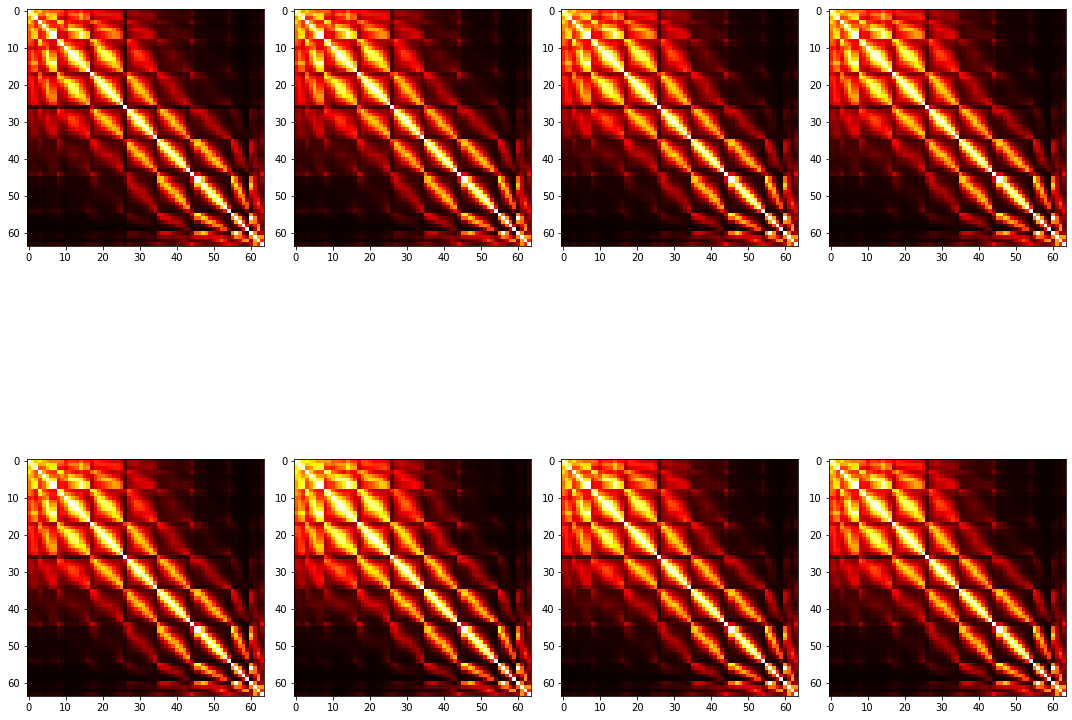

In [ ]:
fig = plt.figure(figsize = (15, 15))
plt.subplot(241)
plt.imshow(np.median(A[:,0,:,:], axis = 0), cmap = 'hot')
plt.subplot(242)
plt.imshow(np.median(A[:,1,:,:], axis = 0), cmap = 'hot')
plt.subplot(243)
plt.imshow(np.median(A[:,2,:,:], axis = 0), cmap = 'hot')
plt.subplot(244)
plt.imshow(np.median(A[:,3,:,:], axis = 0), cmap = 'hot')
plt.subplot(245)
plt.imshow(np.median(A[:,4,:,:], axis = 0), cmap = 'hot')
plt.subplot(246)
plt.imshow(np.median(A[:,5,:,:], axis = 0), cmap = 'hot')
plt.subplot(247)
plt.imshow(np.median(A[:,6,:,:], axis = 0), cmap = 'hot')
plt.subplot(248)
plt.imshow(np.median(A[:,7,:,:], axis = 0), cmap = 'hot')
fig.tight_layout()

In [ ]:
N, F, C, _ = A.shape
ones = tf.ones_like(A[0, 0, ...])
mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s
mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s
mask = tf.cast(mask_a - mask_b, dtype = tf.bool) #Make a bool mask
A = tf.boolean_mask(A, mask, axis = 2) #(N, F, C(C - 1)/2)
A.set_shape([N, F, int(C*(C - 1)*0.5)])

In [ ]:
A_l = A[y_train == 0]
A_r = A[y_train == 1]

m_l = np.median(A_l, axis = 0)
m_r = np.median(A_r, axis = 0)

q1_l, q3_l = np.percentile(A_l, [25, 50], axis = 0)
q1_r, q3_r = np.percentile(A_r, [25, 50], axis = 0)

fig, axs = plt.subplots(nrows = m_l.shape[0], ncols = 1, figsize = (30, 40))

for f in range(m_l.shape[0]):
  axs[f].fill_between(np.arange(m_l[f].shape[0]), q1_l[f], q3_l[f], alpha=.5, linewidth=0)
  axs[f].plot(m_l[f], 'r', label = 'left')
  axs[f].fill_between(np.arange(m_r[f].shape[0]), q1_r[f], q3_r[f], alpha=.5, linewidth=0)
  axs[f].plot(m_r[f], 'b', label = 'right')
  axs[f].legend()

fig.tight_layout()

In [ ]:
A = tf.linalg.normalize(A, ord = 'euclidean', axis = -1)[0] #Normalize connectivities vectors
A = tf.transpose(A, perm  = (1, 0, 2)) #(F, N, C(C - 1)/2)
Ka = tf.linalg.matmul(A, A, transpose_b = True) #(F, N, N)

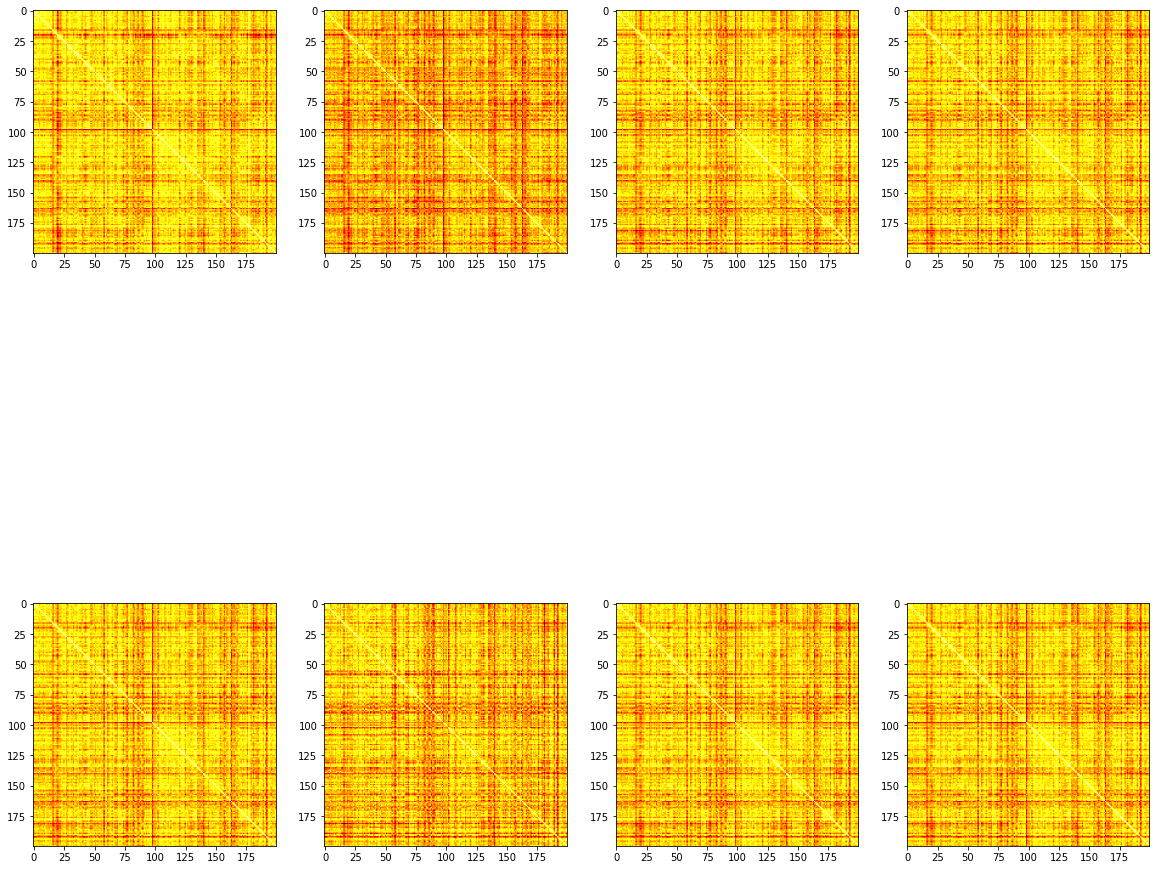

In [ ]:
fig = plt.figure(figsize = (20, 20))
plt.subplot(241)
plt.imshow(Ka[0], cmap = 'hot')
plt.subplot(242)
plt.imshow(Ka[1], cmap = 'hot')
plt.subplot(243)
plt.imshow(Ka[2], cmap = 'hot')
plt.subplot(244)
plt.imshow(Ka[3], cmap = 'hot')
plt.subplot(245)
plt.imshow(Ka[4], cmap = 'hot')
plt.subplot(246)
plt.imshow(Ka[5], cmap = 'hot')
plt.subplot(247)
plt.imshow(Ka[6], cmap = 'hot')
plt.subplot(248)
plt.imshow(Ka[7], cmap = 'hot')

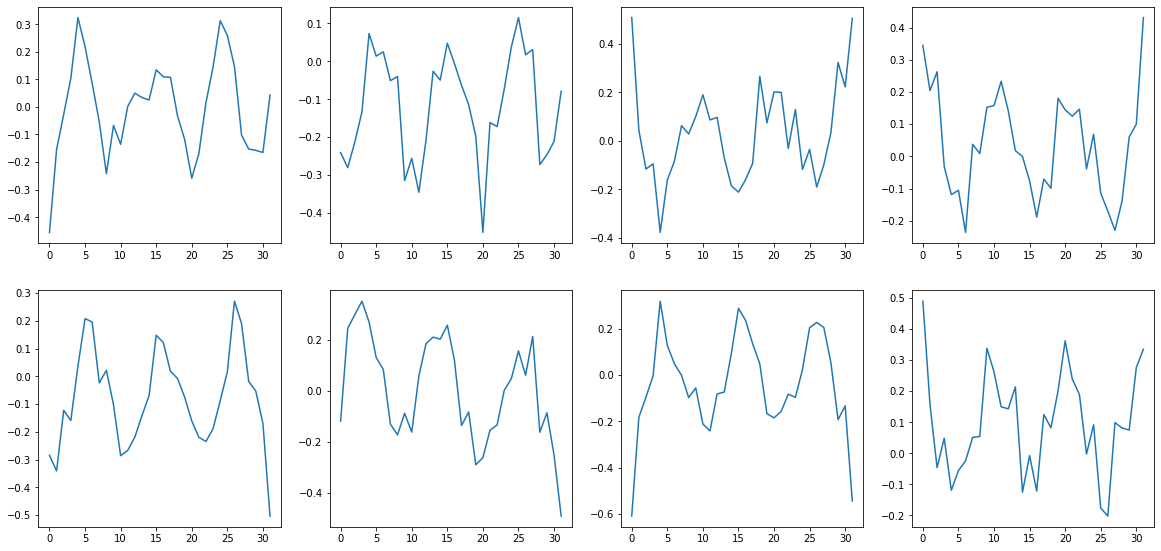

In [ ]:
temp_conv = model.get_layer('Temporal_Conv2D')
weights = temp_conv.get_weights()
fig = plt.figure(figsize = (20, 20))
plt.subplot(441)
plt.plot(weights[0][0,:,0,0])
plt.subplot(442)
plt.plot(weights[0][0,:,0,1])
plt.subplot(443)
plt.plot(weights[0][0,:,0,2])
plt.subplot(444)
plt.plot(weights[0][0,:,0,3])
plt.subplot(445)
plt.plot(weights[0][0,:,0,4])
plt.subplot(446)
plt.plot(weights[0][0,:,0,5])
plt.subplot(447)
plt.plot(weights[0][0,:,0,6])
plt.subplot(448)
plt.plot(weights[0][0,:,0,7])

In [ ]:
gfc_layer = model.get_layer('gfc')
gammad = gfc_layer.get_weights()[0]
gamma = tf.pow(10., gammad)
print('gammad = ', gammad) 
print('gamma = ', gamma.numpy()) #same for sbj 51, 43, almost same as sbj2

gammad =  -0.60844755
gamma =  0.24634993


In [ ]:
print('acc = ', accuracy_score(y_train, np.argmax(Y, axis = 1)))

acc =  1.0
